# Digital Image Processing Project: Edge Detection for Structural Similarity

In [1]:
# Required Pytorch libraries/functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, SubsetRandomSampler, Subset 

# General Libraries for processing/output
import cv2
import random
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Metrics, Filters
from skimage import filters, feature
from scipy.ndimage import gaussian_laplace
from sklearn.metrics import jaccard_score
from networkx.algorithms import graph_edit_distance
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

C:\Users\hoxto\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Custom Dataset Class for MNIST

In [2]:
class MNISTPatchesDataset(Dataset):
    def __init__(self, mnist_dataset, edge_detection=None):
        """
        Initialize the dataset with the MNIST dataset and edge detection option.

        Args:
            mnist_dataset (torch Dataset): Original MNIST dataset.
            edge_detection (str or None): Edge detection method.
                Options: 'sobel', 'prewitt', 'canny', or None (for random selection).
        """
        self.mnist_dataset = mnist_dataset
        self.edge_detection = edge_detection
        self.mnist_patches_dataset = []

        for image, label in self.mnist_dataset:
            image = image.squeeze()  # (1,28,28) -> (28,28)

            if self.edge_detection is None:
                # Randomly select an edge detection method
                edge_detection_method = random.choice(['sobel', 'prewitt', 'canny'])
            else:
                edge_detection_method = self.edge_detection

            edge_image = self.apply_edge_detection(image, edge_detection_method)

            # Generate patches
            original_patches = self.generate_patches(image)
            edge_patches = self.generate_patches(edge_image) # 4 * (14.14)

            for i, (original, edge) in enumerate(zip(original_patches, edge_patches)):
                edge = edge.unsqueeze(0) # (14,14) -> (1,14,14)
                original = original.unsqueeze(0)
                text = str(label) + "_" + edge_detection_method + "_" + str(i)
                self.mnist_patches_dataset.append((text, original, edge))

    def __len__(self):
        return len(self.mnist_patches_dataset)

    def __getitem__(self, idx):
        return self.mnist_patches_dataset[idx]

    def generate_patches(self, image):
        height, width = image.shape[-2:]
        patch_height = height // 2
        patch_width = width // 2

        patches = [
            image[:patch_height, :patch_width],       # Top-left patch
            image[:patch_height, patch_width:],       # Top-right patch
            image[patch_height:, :patch_width],       # Bottom-left patch
            image[patch_height:, patch_width:],       # Bottom-right patch
        ]

        return patches

    def segment_with_processing(self, idx, edge_type):
        output = []
        image, label = self.mnist_dataset[idx]
        image = image.squeeze()

        patches = self.generate_patches(image)
        for i, patch in enumerate(patches):
            edge_patch = self.apply_edge_detection(patch, edge_type)
            edge_patch = edge_patch.unsqueeze(0)
            patch = patch.unsqueeze(0)
            text = str(label) + "_" + edge_type + "_" + str(i)
            output.append((text, patch, edge_patch))

        return output

    def apply_edge_detection(self, image, method):
        if method == 'sobel':
            return self.apply_sobel_operator(image)
        elif method == 'prewitt':
            return self.apply_prewitt_operator(image)
        elif method == 'canny':
            return self.apply_canny_edge_detector(image)
        else:
            return image  # Return original patch if method is unknown

    def apply_sobel_operator(self, image):
        image_np = image.numpy()
        sobel_x = cv2.Sobel(image_np, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image_np, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).astype(np.float32)
        if (np.max(sobel_magnitude) > 1):
            scale_factor = 1 / np.max(sobel_magnitude)
            sobel_magnitude = (sobel_magnitude * scale_factor).astype(np.float32)
        return torch.tensor(sobel_magnitude, dtype=torch.float32)

    def apply_prewitt_operator(self, image):
        prewitt_magnitude = filters.prewitt(image.numpy())
        return torch.tensor(prewitt_magnitude, dtype=torch.float32)

    def apply_canny_edge_detector(self, image):
        canny_edges = feature.canny(image.numpy())
        return torch.tensor(canny_edges, dtype=torch.float32)


# Loading a subset of MNIST into our custom dataset

In [3]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

subset_size, subset_size2 = 2000, 1000
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset_indices2 = torch.randperm(len(dataset))[:subset_size2]
train_dataset = Subset(dataset, subset_indices)
val_dataset = Subset(dataset, subset_indices2)

# Create an instance of the custom dataset
train_dataset_patches = MNISTPatchesDataset(train_dataset)
val_dataset_patches = MNISTPatchesDataset(val_dataset)

# Displaying Edge Filtered Patches from our dataset

In [4]:
def display_sample_from_dataset(dataset, num_samples=4):
    # Calculate the number of columns in the subplot grid
    num_cols = 4  # Display patches in 4 columns
    num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate number of rows needed

    # Plot the selected samples in a grid layout
    plt.figure(figsize=(16, 2 * num_rows))
    for i in range(num_samples):
        edge_label, original_patch, edge_patch = dataset[i]  # Get patch from the dataset
        original_patch = original_patch.detach().cpu()
        edge_patch = edge_patch.detach().cpu()

        # Calculate subplot indices based on row-major order
        row_index = i // num_cols
        col_index = i % num_cols

        # Compute the subplot index (1-based) within the grid
        subplot_index = row_index * num_cols + col_index + 1

        # Display the edge-detected patch with edge label in the odd-numbered subplot
        plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index - 1)
        plt.imshow(edge_patch.squeeze(), cmap='gray')
        plt.xticks([]), plt.yticks([])  # Hide axis ticks
        plt.title(f"Edge Label: {edge_label}", fontsize=10, color='red')  # Display edge label as title

        # Display the original patch in the even-numbered subplot
        plt.subplot(num_rows, 2 * num_cols, 2 * subplot_index)
        plt.imshow(original_patch.squeeze(), cmap='gray')
        plt.xticks([]), plt.yticks([])  # Hide axis ticks
        plt.title("Original Patch", fontsize=10)  # Display title for original patch

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()


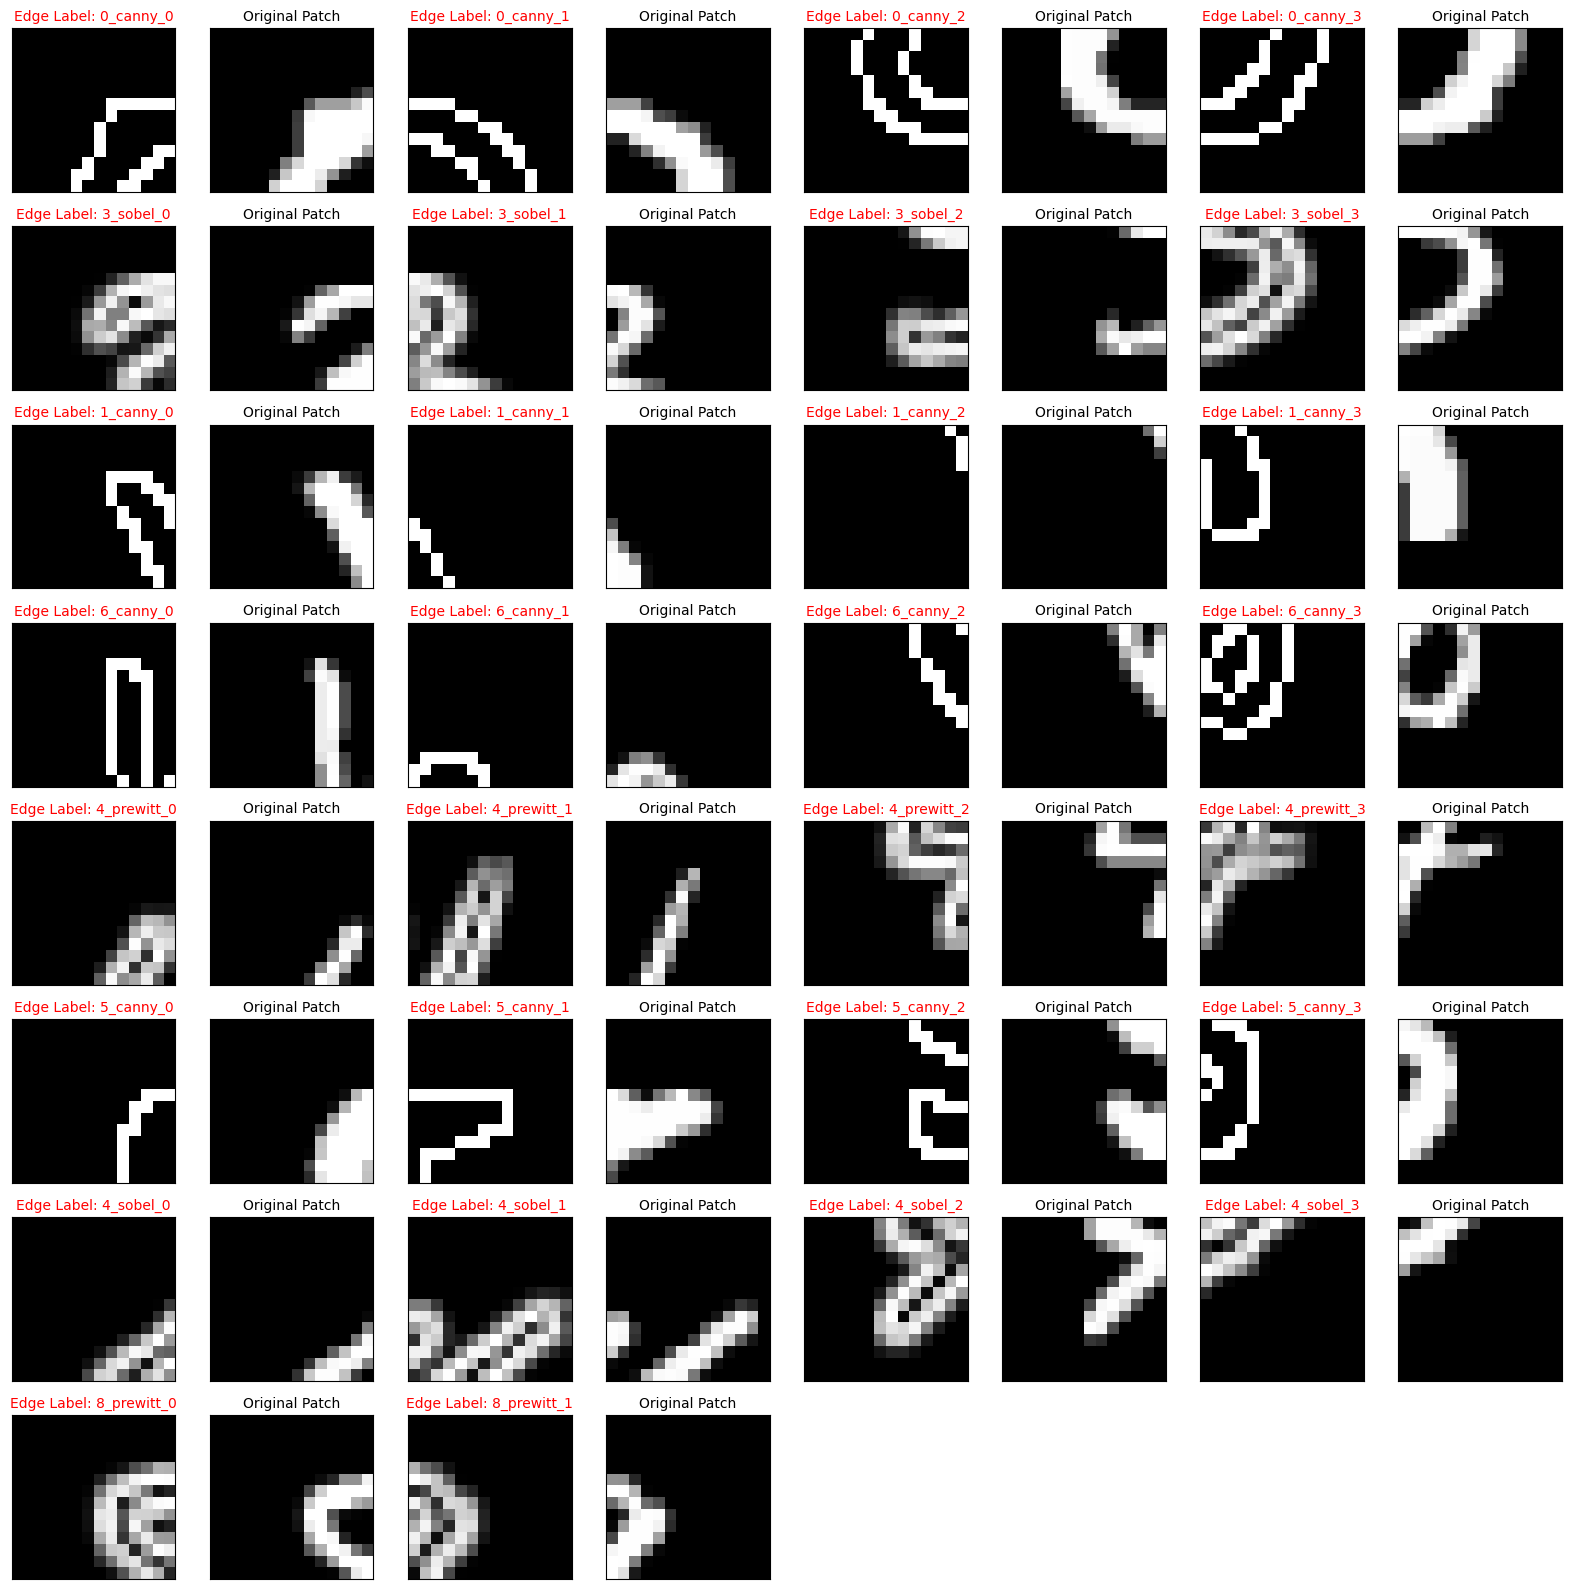

In [5]:
display_sample_from_dataset(train_dataset_patches, 30)

# Convolutional Disentangled Variational Autoencoder Model

In [6]:
class VAE(nn.Module):

    def __init__(self, input_shape=(1, 14, 14), dim_code=32):
        super().__init__()

        # Encoder

        # Image resolution formulae: [(input featuers + 2*padding - kernel size) / stride ] + 1 
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Flatten mu and logsigma
        self.flatten_mu = nn.Linear(32 * 4 * 4, out_features=dim_code)
        self.flatten_logsigma = nn.Linear(32 * 4 * 4, out_features=dim_code)

        # Decoder
        self.decode_linear = nn.Linear(dim_code, 32 * 4 * 4)
        self.decode_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.decode_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        z = self.gaussian_sampler(mu, logsigma)
        return z, mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.decode_linear(z)
        x = x.view(x.size(0), 32, 4, 4)
        x = F.relu(self.decode_conv1(x))
        reconstruction = torch.sigmoid(self.decode_conv2(x))
        return reconstruction

    def forward(self, x):
        z, mu, logsigma = self.encode(x)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


# Loss Function

In [7]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction, beta):
    return (beta * KL_divergence(mu, logsigma)) + log_likelihood(x, reconstruction)

# Functions for Training the Model

In [8]:
def train_epoch(model, criterion, optimizer, data_loader, beta):
    train_losses_per_epoch = []
    model.train()
    for _, image_batch, edge_batch in data_loader:

        edge_batch = edge_batch.to(device)    
        image_batch = image_batch.to(device)
        mu, logsigma, reconstruction = model(edge_batch)
        loss = criterion(image_batch.to(device).float(), mu, logsigma, reconstruction, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    return np.mean(train_losses_per_epoch), mu, logsigma, reconstruction

In [9]:
def eval_epoch(model, criterion, data_loader, beta):
    val_losses_per_epoch = []
    model.eval()
    with torch.no_grad():
        for _, image_batch, edge_batch in data_loader:
            edge_batch = edge_batch.to(device)
            image_batch = image_batch.to(device)
            mu, logsigma, reconstruction = model(edge_batch)
            
            loss = criterion(image_batch.float(), mu, logsigma, reconstruction, beta)
            
            val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch)

In [10]:
def plot_output(model, epoch, epochs, train_loss, val_loss, size = 5):
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    for k in range(size):
        ax = plt.subplot(2, size, k + 1)
        edge_label, _, img = train_dataset_patches[k]

        img = img.unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
             mu, logsigma, reconstruction  = model(img)

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        plt.title(f"Edge Label: {edge_label}", fontsize=10, color='red')  # Display edge label as title
        plt.axis('off')
        
        ax = plt.subplot(2, size, k + 1 + size)
        plt.imshow(reconstruction.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')

        if k == size//2:
            ax.set_title('Reconstructed Structural Output')
    plt.suptitle('%d / %d - loss: %f val_loss: %f' % (epoch+1, epochs, train_loss, val_loss))
    plt.show()

# Training Loop

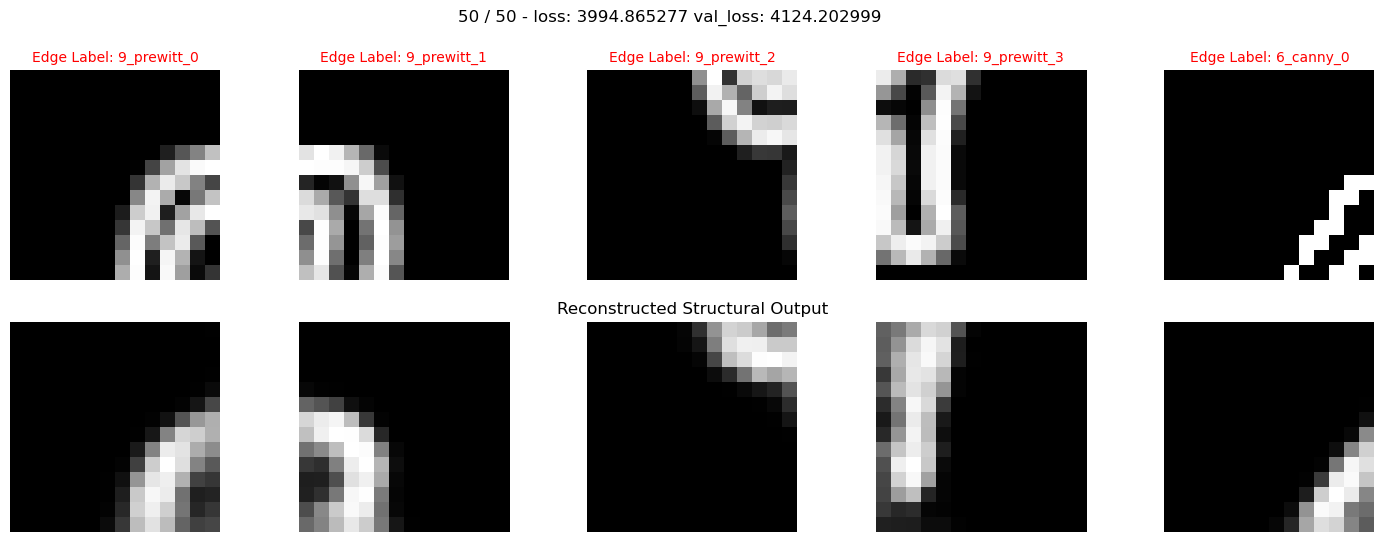

epoch: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


In [11]:
dim_code = 2
batch_size = 128
learning_rate = 1e-3
beta = 0.3
weight_decay = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset_patches, batch_size=batch_size)
val_loader = DataLoader(val_dataset_patches, batch_size=batch_size)

criterion = loss_vae
autoencoder_vae = VAE(dim_code=dim_code).to(device)
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=learning_rate, weight_decay=weight_decay)

epochs = 50
loss = {'train_loss':[],'val_loss':[]}
with tqdm(desc="epoch", total=epochs) as pbar_outer:
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        train_loss, mu, logsigma, reconstruction = train_epoch(autoencoder_vae, criterion, optimizer, train_loader, beta)
        val_loss = eval_epoch(autoencoder_vae, criterion, val_loader, beta)
        pbar_outer.update(1)

        loss['train_loss'].append(train_loss)
        loss['val_loss'].append(val_loss)
        plot_output(autoencoder_vae, epoch, epochs, train_loss, val_loss = val_loss, size = 5)

# Loss Output

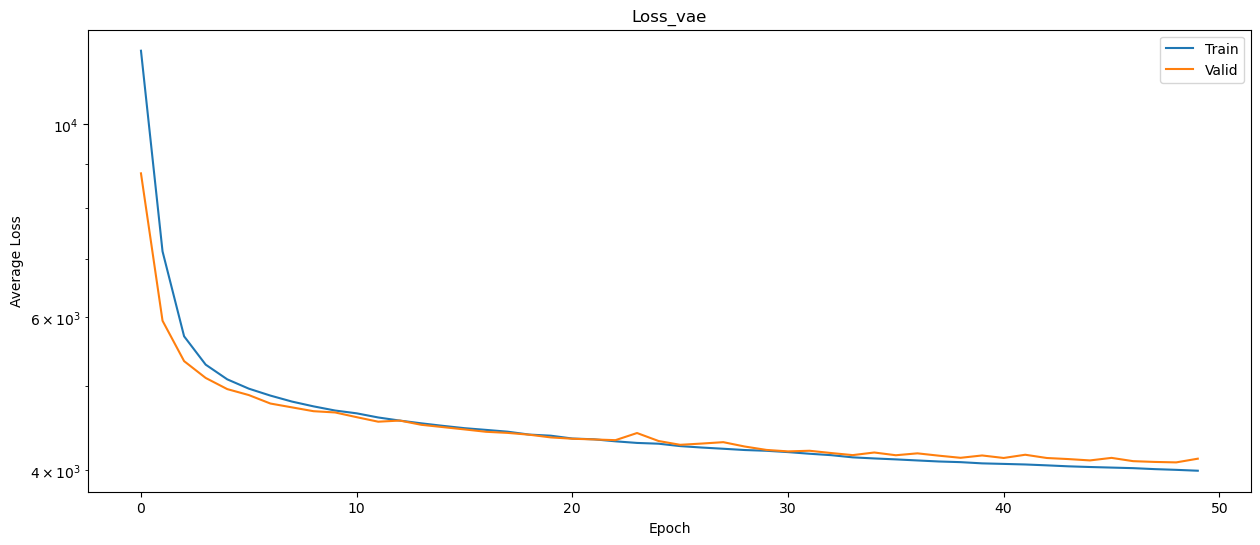

In [12]:
plt.figure(figsize=(15, 6))
plt.semilogy(loss['train_loss'], label='Train')
plt.semilogy(loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss_vae')
plt.show()

# Model Saving & Loading

In [13]:
save_path = f'vae_model_{dim_code}_{beta}.pth'
torch.save(autoencoder_vae, save_path)

In [10]:
dim_code = 2
beta = 0.3

load_path =  f'vae_model_{dim_code}_{beta}.pth'
autoencoder_vae = torch.load(load_path)
autoencoder_vae = autoencoder_vae.to("cuda")
autoencoder_vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (flatten_mu): Linear(in_features=512, out_features=2, bias=True)
  (flatten_logsigma): Linear(in_features=512, out_features=2, bias=True)
  (decode_linear): Linear(in_features=2, out_features=512, bias=True)
  (decode_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decode_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

# Display Input and Reconstruction

In [11]:
def display_input_and_reconstructed_image(dataset, idx):
    # Get the input image
    edge_label, _, input_image = dataset[idx]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Display the input image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(edge_label)
    plt.imshow(input_image.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    
    # Pass input image through the VAE model
    with torch.no_grad():
        input_image = input_image.unsqueeze(0).to(device)
        _, _, recon_image = autoencoder_vae(input_image)
        # print(autoencoder_vae.encoder(input_image))
    
    # Display the reconstructed image
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(recon_image.detach().squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.show()

In [12]:
val_dataset_patches_sobel = MNISTPatchesDataset(val_dataset, 'sobel')
val_dataset_patches_canny = MNISTPatchesDataset(val_dataset, 'canny')
val_dataset_patches_prewitt = MNISTPatchesDataset(val_dataset, 'prewitt')

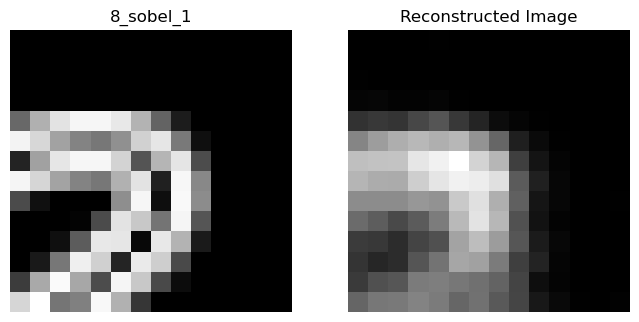

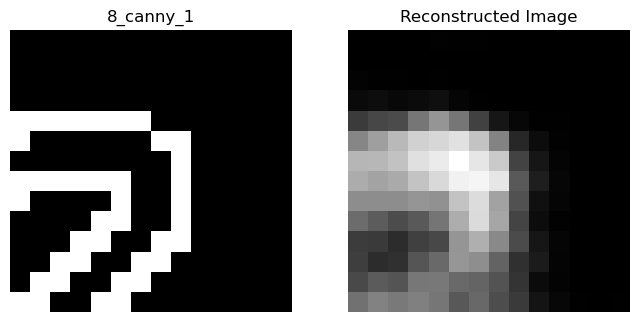

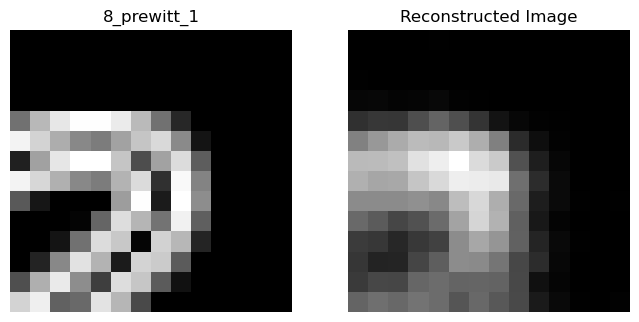

In [13]:
index = 9
display_input_and_reconstructed_image(val_dataset_patches_sobel, index)
display_input_and_reconstructed_image(val_dataset_patches_canny, index)
display_input_and_reconstructed_image(val_dataset_patches_prewitt, index)

# Latent Space Variables

In [14]:
latent_space = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for label, _, image in tqdm(val_dataset_patches):
    img = image.unsqueeze(0).to(device)

    autoencoder_vae.eval()
    with torch.no_grad():
        latent, _, _ = autoencoder_vae.encode(img)

    latent = latent.flatten().cpu().numpy()
    sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
    sample['label'] = label
    latent_space.append(sample)

latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(str)
latent_space

100%|██████████| 4000/4000 [00:10<00:00, 373.83it/s]


Encoded_0  Encoded_1      label
0      0.500813  -1.566769  6_sobel_0
1     -0.878354   0.412221  6_sobel_1
2      2.198065   0.049021  6_sobel_2
3     -0.525508   2.040808  6_sobel_3
4      0.837152   0.603365  2_sobel_0
...         ...        ...        ...
3995  -0.590357   0.455889  6_canny_3
3996   0.655593  -1.048021  3_sobel_0
3997  -1.303780  -0.672198  3_sobel_1
3998   2.381032  -2.018732  3_sobel_2
3999  -1.136413   0.628003  3_sobel_3

[4000 rows x 3 columns]

# Visuallizing Latent Space

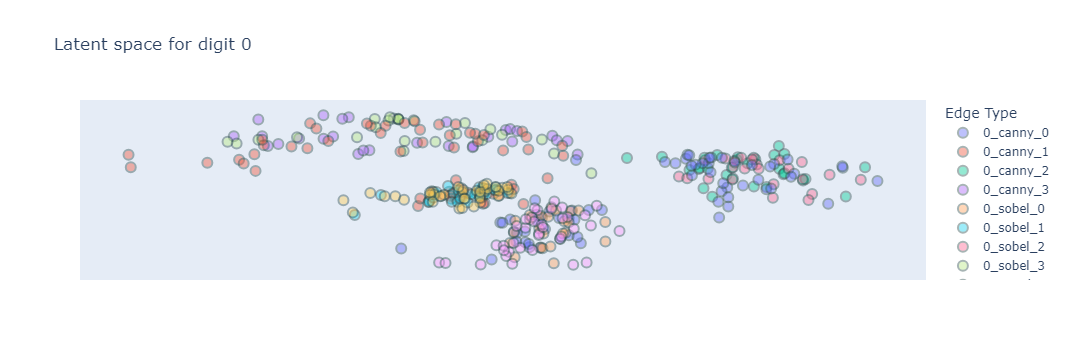

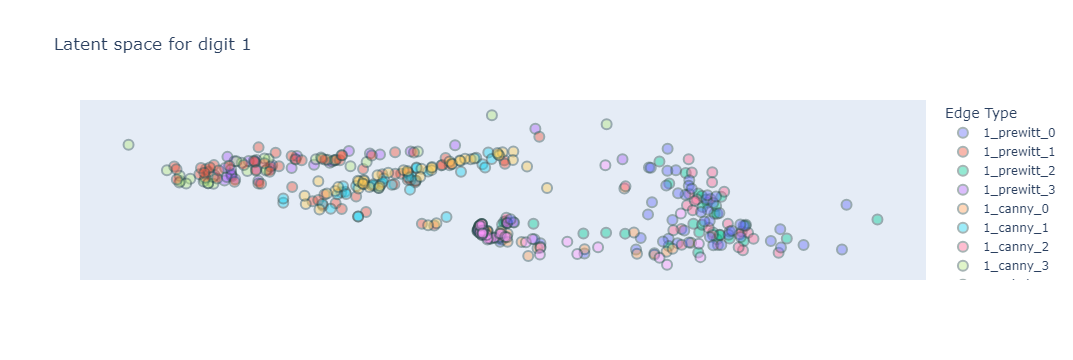

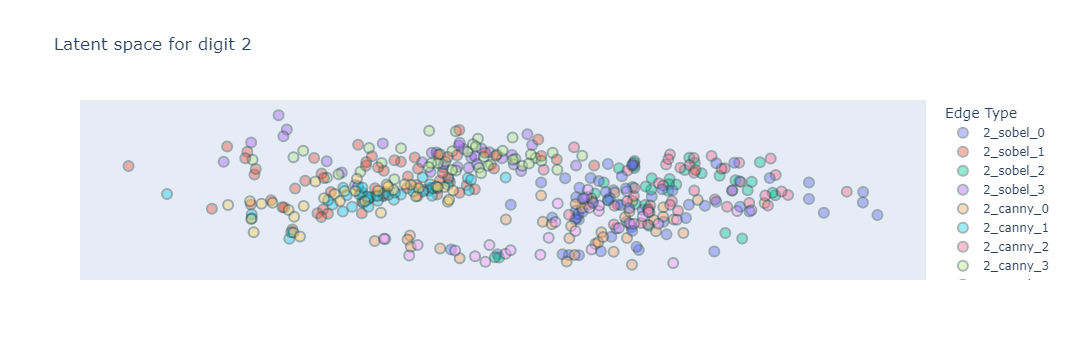

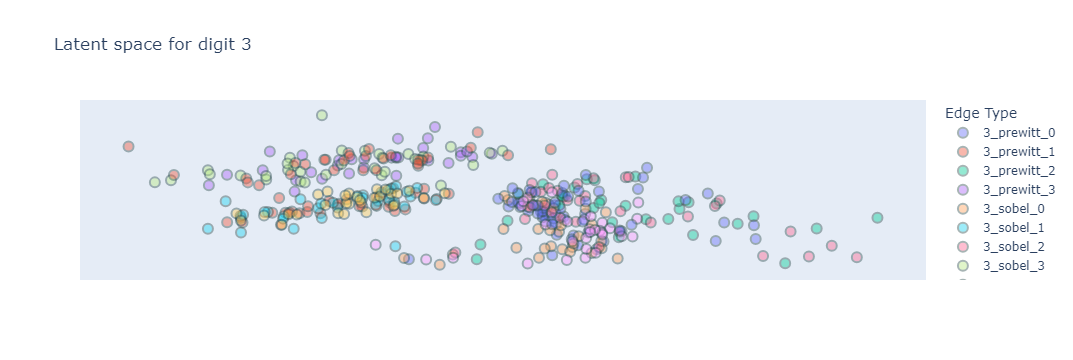

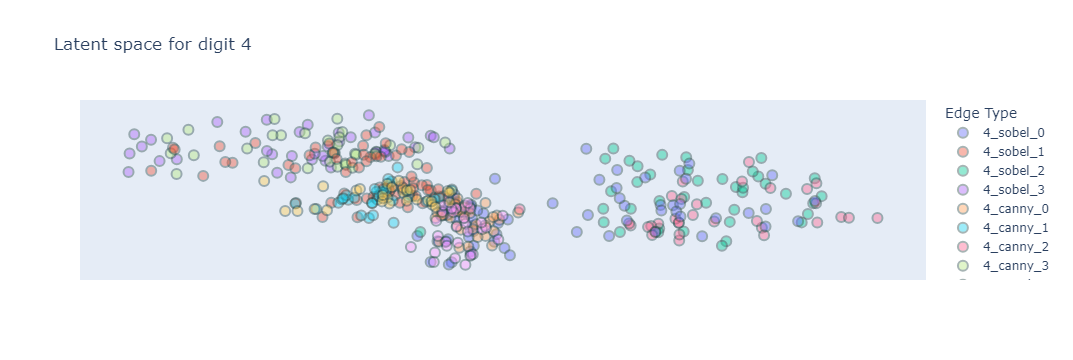

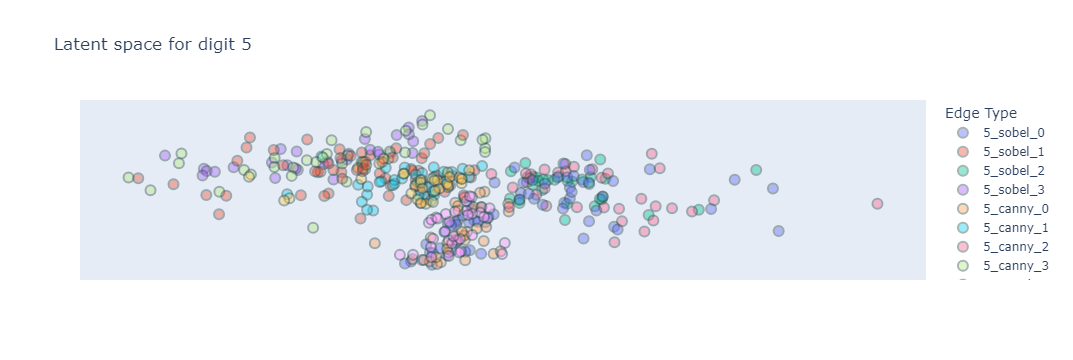

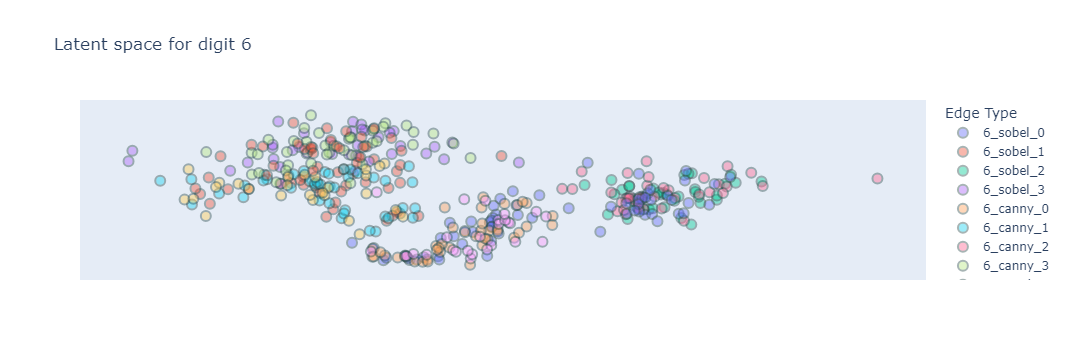

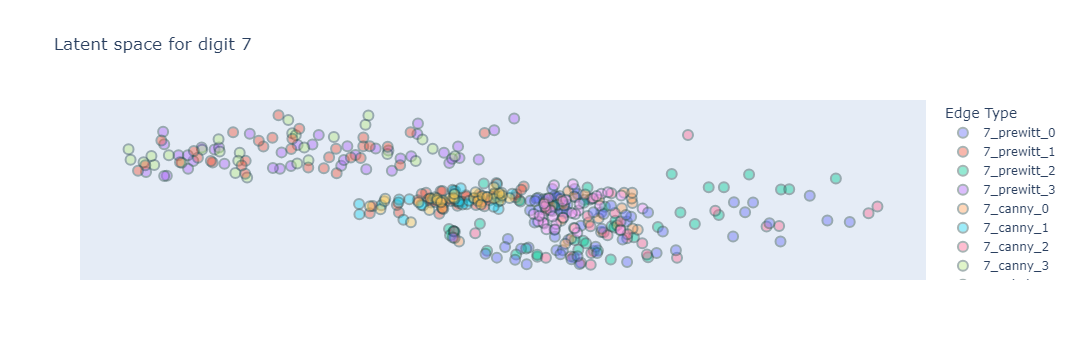

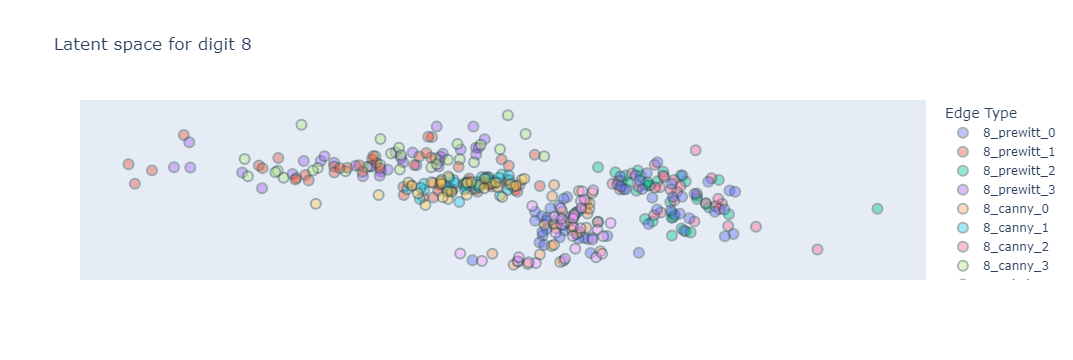

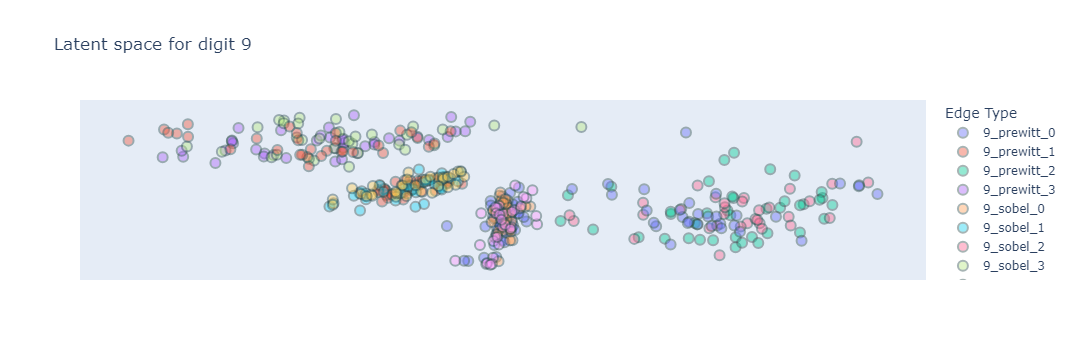

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def extract_first_digit(label):
    return int(label.split('_')[0])

for desired_digit in range(10):
    latent_space['FirstDigit'] = latent_space['label'].apply(extract_first_digit)
    filtered_df = latent_space[latent_space['FirstDigit'] == desired_digit]
    filtered_df
    
    fig = px.scatter(filtered_df, x='Encoded_0', y='Encoded_1', color='label', opacity=0.42, labels={'label': "Edge Type "}, title=f"Latent space for digit {desired_digit}").for_each_trace(lambda t: t.update(name=t.name.replace("=",": ")))
    fig.update_traces(marker=dict(size=10, line=dict(width=2,color='DarkSlateGrey')),selector=dict(mode='markers'))
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

# Compute Graph Similarity

In [16]:
# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

subset_size = 1000
subset_indices = torch.randperm(len(dataset))[:subset_size]
dataset = Subset(dataset, subset_indices)

# Create an instance of the custom dataset
patch_dataset = MNISTPatchesDataset(dataset)

In [35]:
def display_pic_and_get_metrics(data, only_count_edges):
    fig, ax = plt.subplots(2, 4, figsize=(16, 8))  # Increase width to fit 4 images per row
    graph_info = []
    
    # Plot each patch with its label in the specified layout
    for i in range(4):
        row = i // 2
        col = i % 2
        
        # Display original image
        original_image = data[i][2].squeeze().numpy()
        ax[row, col].imshow(original_image, cmap='gray')
        ax[row, col].set_title(data[i][0])
        ax[row, col].axis('off')

        if only_count_edges:
            # When only counting edges, do not reconstruct or display additional images
            image = data[i][2].to(device).unsqueeze(0)
            edge_count = torch.sum(image > 0)
            graph_info.append([data[i][0], edge_count])
            ax[row, col+2].axis('off')
        else:        
            # Encode and reconstruct the image
            image = data[i][2].to(device).unsqueeze(0)
            hehe_image = data[i][1].to(device).unsqueeze(0)
            with torch.no_grad():
                latent, _, _ = autoencoder_vae.encode(image)
                _, _, recon_image = autoencoder_vae(image)
            
            # Display reconstructed image next to original image
            ax[row, col+2].imshow(recon_image.cpu().squeeze().numpy(), cmap='gray')
            # ax[row, col+2].imshow(hehe_image.cpu().squeeze().numpy(), cmap='gray')
            ax[row, col+2].set_title("Reconstructed")
            ax[row, col+2].axis('off')
            
            # Store graph information with latent representation
            graph_info.append([data[i][0], latent])
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    return graph_info

def createGraph(edgelist):
    
    G = nx.MultiDiGraph()

    # Add directed edges with weights to the graph
    for source, target, weight in edgelist:
        G.add_edge(source, target, weight=weight)
    return G

def euclidean_distance(weights1, weights2):
    return np.sqrt(np.sum((weights1 - weights2) ** 2))

def latent_cosine_similarity(u):
    v = reference_vector = np.ones_like(u)
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def convert_data_to_edges(data):
    edges = []
    node_map = {item[0]: idx for idx, item in enumerate(data, start=1)}  # Map node names to indices

    for edge_type, tensor in data:
        source_node = edge_type
        source_idx = node_map[source_node]

        # Find potential target nodes (excluding the source node)
        potential_targets = [item[0] for item in data if item[0] != edge_type]

        for target_node in potential_targets:
            target_idx = node_map[target_node]
            weight = tensor.squeeze().tolist()
            edges.append((source_node, target_node, weight))

    return edges

def compute_graph_similarity(idx1, edge1, idx2, edge2, threshold, only_count_edges = False):
    image1 = patch_dataset.segment_with_processing(idx1, edge1)
    image2 = patch_dataset.segment_with_processing(idx2, edge2)
    
    graph_info1 = display_pic_and_get_metrics(image1, only_count_edges)
    graph_info2 = display_pic_and_get_metrics(image2, only_count_edges)
    
    print("Information of every patch and it's latent variables\n")
    display(graph_info1)
    print()
    display(graph_info2)
    print()

    edgelist1 = convert_data_to_edges(graph_info1)
    edgelist2 = convert_data_to_edges(graph_info2)
    
    print("Edge list of Graph 1\n")
    display(edgelist1)
    print("\nEdge list of Graph 2\n")
    display(edgelist2)
    print()
    
    graph1 = createGraph(edgelist1)
    graph2 = createGraph(edgelist2)

    # pos = nx.spring_layout(graph1)
    # nx.draw(graph1, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black')
    # edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph1.edges(data=True)])
    # nx.draw_networkx_edge_labels(graph1, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)
    # plt.show()

    # pos = nx.spring_layout(graph2)
    # nx.draw(graph2, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black')
    # edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph2.edges(data=True)])
    # nx.draw_networkx_edge_labels(graph2, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)
    # plt.show()

    weights1 = np.array([weight for _, _, weight in edgelist1])
    weights2 = np.array([weight for _, _, weight in edgelist2])
    # print(weights1, weights2)
    if only_count_edges:
        sim = euclidean_distance(weights1, weights2)
        print("Similarity Score = ", sim, " score closer to 0 means more similar")
    else:
        sim = cosine_similarity(weights1.reshape(1, -1), weights2.reshape(1, -1))[0][0]
        print("Similarity Score = ", sim)
        if sim > threshold:
            print("These graphs are similar")    
    

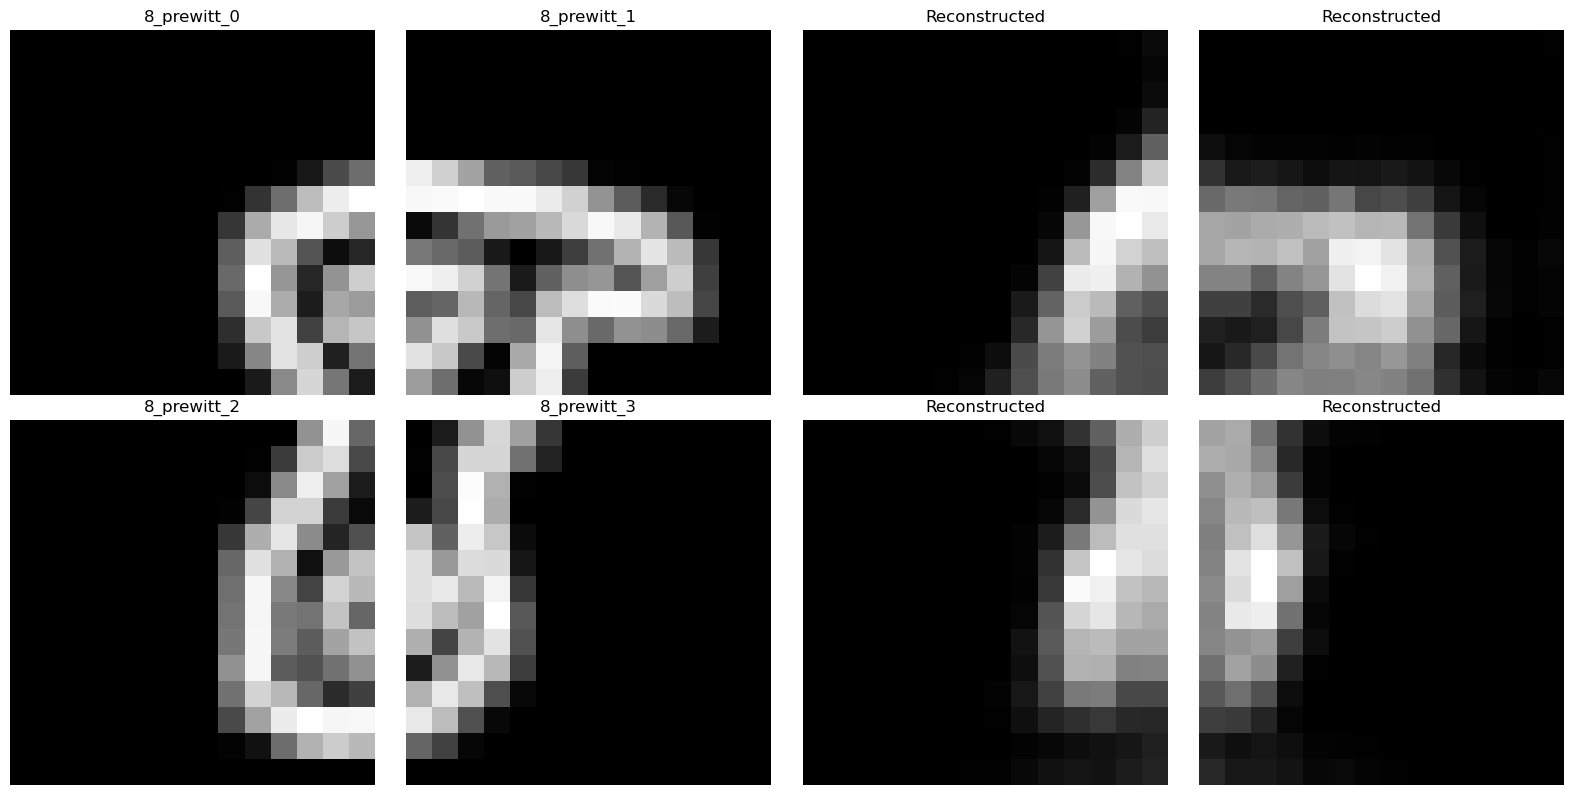

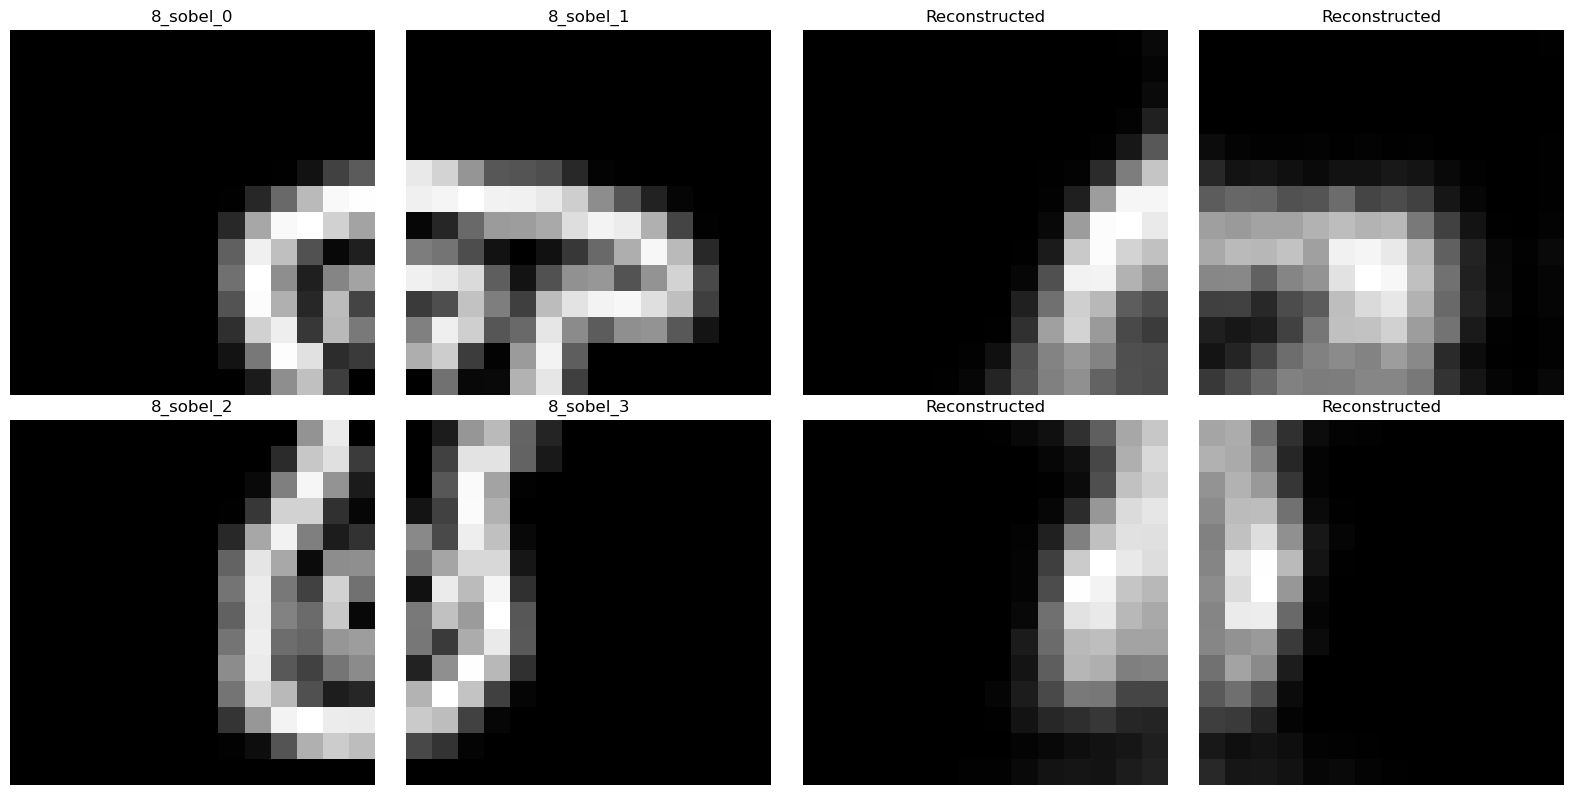

Information of every patch and it's latent variables



[['8_prewitt_0', tensor([[ 0.5930, -1.4843]], device='cuda:0')],
 ['8_prewitt_1', tensor([[-0.1062, -0.1220]], device='cuda:0')],
 ['8_prewitt_2', tensor([[ 1.3362, -0.8944]], device='cuda:0')],
 ['8_prewitt_3', tensor([[-1.4353,  0.5703]], device='cuda:0')]]

[['8_sobel_0', tensor([[ 0.5714, -1.4539]], device='cuda:0')],
 ['8_sobel_1', tensor([[-0.0867, -0.1326]], device='cuda:0')],
 ['8_sobel_2', tensor([[ 1.3071, -0.8474]], device='cuda:0')],
 ['8_sobel_3', tensor([[-1.4600,  0.5592]], device='cuda:0')]]


Edge list of Graph 1



[('8_prewitt_0', '8_prewitt_1', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_0', '8_prewitt_2', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_0', '8_prewitt_3', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_1', '8_prewitt_0', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_1', '8_prewitt_2', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_1', '8_prewitt_3', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_2', '8_prewitt_0', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_2', '8_prewitt_1', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_2', '8_prewitt_3', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_3', '8_prewitt_0', [-1.435346245765686, 0.5703206062316895]),
 ('8_prewitt_3', '8_prewitt_1', [-1.435346245765686, 0.5703206062316895]),
 ('8_prewitt_3', '8_prewitt_2', [-1.435346245765686, 0.5703206062316895])]


Edge list of Graph 2



[('8_sobel_0', '8_sobel_1', [0.5713964700698853, -1.4539374113082886]),
 ('8_sobel_0', '8_sobel_2', [0.5713964700698853, -1.4539374113082886]),
 ('8_sobel_0', '8_sobel_3', [0.5713964700698853, -1.4539374113082886]),
 ('8_sobel_1', '8_sobel_0', [-0.08670926094055176, -0.13257084786891937]),
 ('8_sobel_1', '8_sobel_2', [-0.08670926094055176, -0.13257084786891937]),
 ('8_sobel_1', '8_sobel_3', [-0.08670926094055176, -0.13257084786891937]),
 ('8_sobel_2', '8_sobel_0', [1.3070589303970337, -0.8474018573760986]),
 ('8_sobel_2', '8_sobel_1', [1.3070589303970337, -0.8474018573760986]),
 ('8_sobel_2', '8_sobel_3', [1.3070589303970337, -0.8474018573760986]),
 ('8_sobel_3', '8_sobel_0', [-1.4600263833999634, 0.559151291847229]),
 ('8_sobel_3', '8_sobel_1', [-1.4600263833999634, 0.559151291847229]),
 ('8_sobel_3', '8_sobel_2', [-1.4600263833999634, 0.559151291847229])]


Similarity Score =  0.9997239411781217
These graphs are similar


In [38]:
compute_graph_similarity(5, 'prewitt', 5, 'sobel', threshold = 0.95)

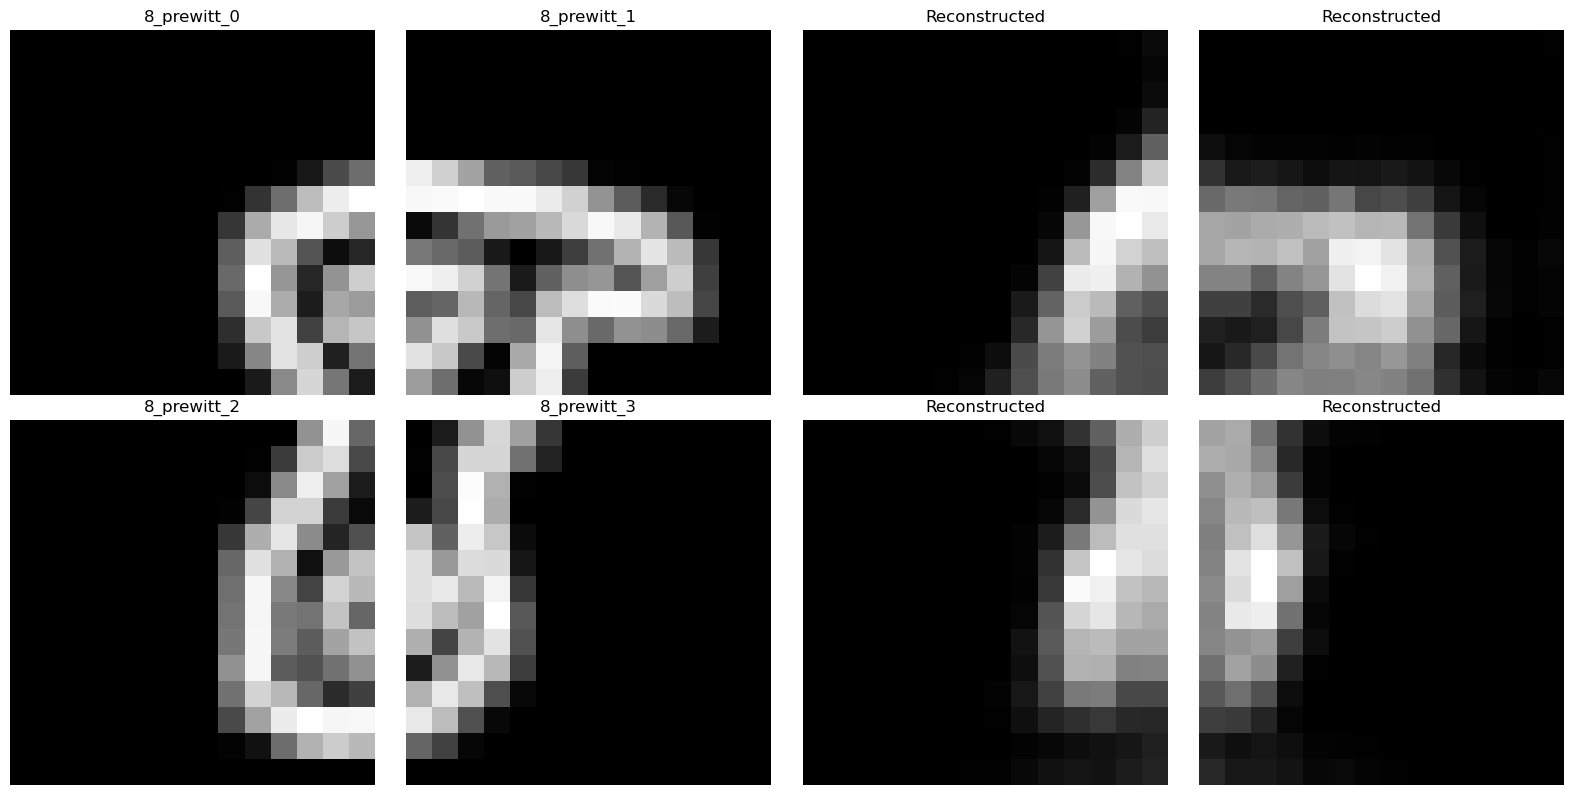

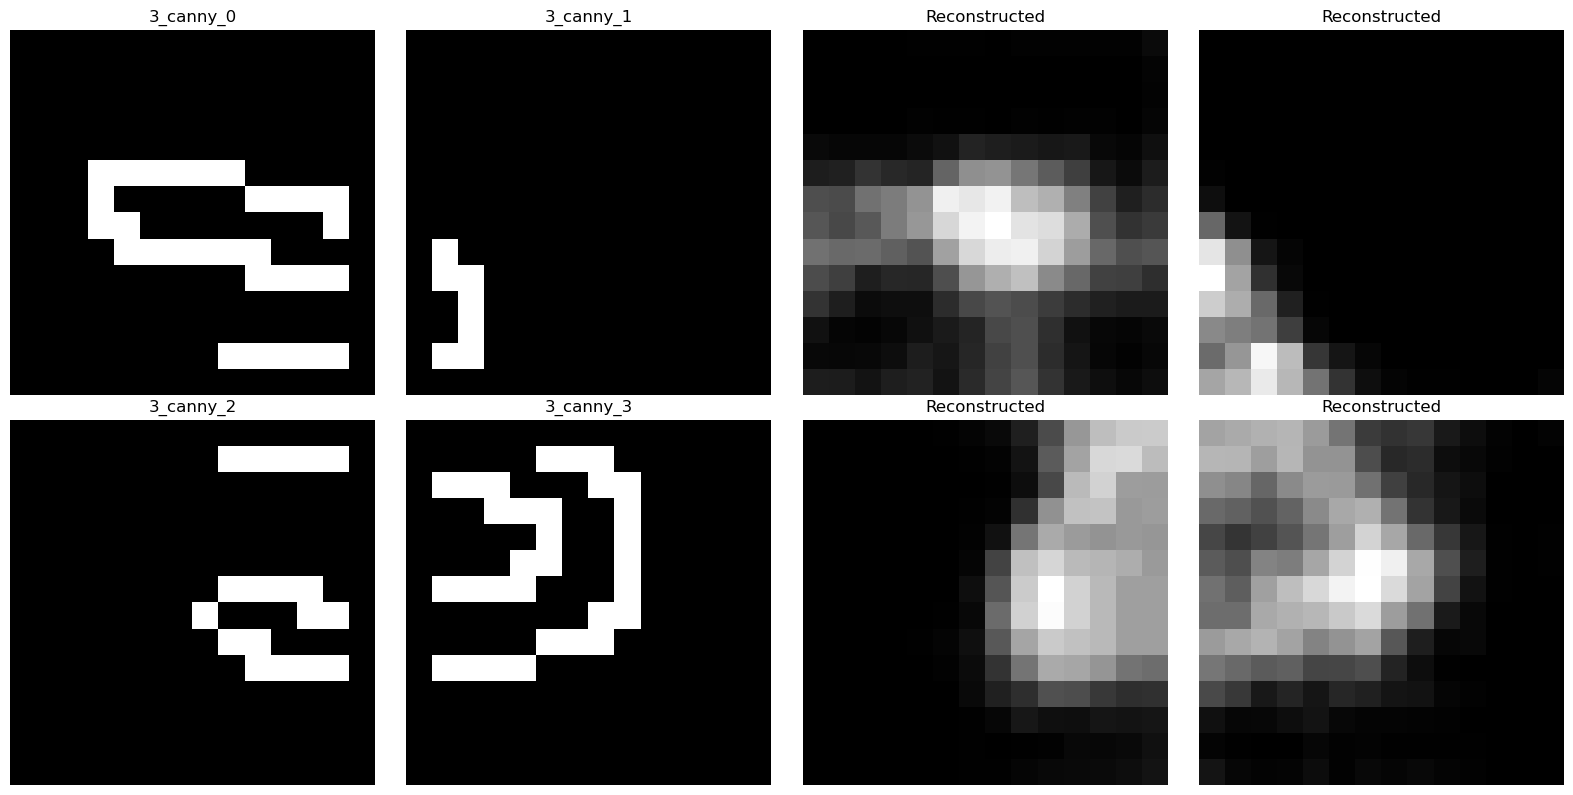

Information of every patch and it's latent variables



[['8_prewitt_0', tensor([[ 0.5930, -1.4843]], device='cuda:0')],
 ['8_prewitt_1', tensor([[-0.1062, -0.1220]], device='cuda:0')],
 ['8_prewitt_2', tensor([[ 1.3362, -0.8944]], device='cuda:0')],
 ['8_prewitt_3', tensor([[-1.4353,  0.5703]], device='cuda:0')]]

[['3_canny_0', tensor([[0.3034, 0.2212]], device='cuda:0')],
 ['3_canny_1', tensor([[-1.5061, -1.3788]], device='cuda:0')],
 ['3_canny_2', tensor([[ 1.3494, -0.0688]], device='cuda:0')],
 ['3_canny_3', tensor([[0.0843, 1.4047]], device='cuda:0')]]


Edge list of Graph 1



[('8_prewitt_0', '8_prewitt_1', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_0', '8_prewitt_2', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_0', '8_prewitt_3', [0.5930311679840088, -1.4843140840530396]),
 ('8_prewitt_1', '8_prewitt_0', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_1', '8_prewitt_2', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_1', '8_prewitt_3', [-0.10620176792144775, -0.12202195078134537]),
 ('8_prewitt_2', '8_prewitt_0', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_2', '8_prewitt_1', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_2', '8_prewitt_3', [1.3361748456954956, -0.8943532705307007]),
 ('8_prewitt_3', '8_prewitt_0', [-1.435346245765686, 0.5703206062316895]),
 ('8_prewitt_3', '8_prewitt_1', [-1.435346245765686, 0.5703206062316895]),
 ('8_prewitt_3', '8_prewitt_2', [-1.435346245765686, 0.5703206062316895])]


Edge list of Graph 2



[('3_canny_0', '3_canny_1', [0.3033517599105835, 0.22124828398227692]),
 ('3_canny_0', '3_canny_2', [0.3033517599105835, 0.22124828398227692]),
 ('3_canny_0', '3_canny_3', [0.3033517599105835, 0.22124828398227692]),
 ('3_canny_1', '3_canny_0', [-1.5061038732528687, -1.3787873983383179]),
 ('3_canny_1', '3_canny_2', [-1.5061038732528687, -1.3787873983383179]),
 ('3_canny_1', '3_canny_3', [-1.5061038732528687, -1.3787873983383179]),
 ('3_canny_2', '3_canny_0', [1.3494325876235962, -0.06877840310335159]),
 ('3_canny_2', '3_canny_1', [1.3494325876235962, -0.06877840310335159]),
 ('3_canny_2', '3_canny_3', [1.3494325876235962, -0.06877840310335159]),
 ('3_canny_3', '3_canny_0', [0.08425556123256683, 1.4046818017959595]),
 ('3_canny_3', '3_canny_1', [0.08425556123256683, 1.4046818017959595]),
 ('3_canny_3', '3_canny_2', [0.08425556123256683, 1.4046818017959595])]


Similarity Score =  0.3479985638739496


In [43]:
compute_graph_similarity(5, 'prewitt', 1, 'canny', threshold = 0.95)

# Using edge counts of patches instead of latent variables for comparison

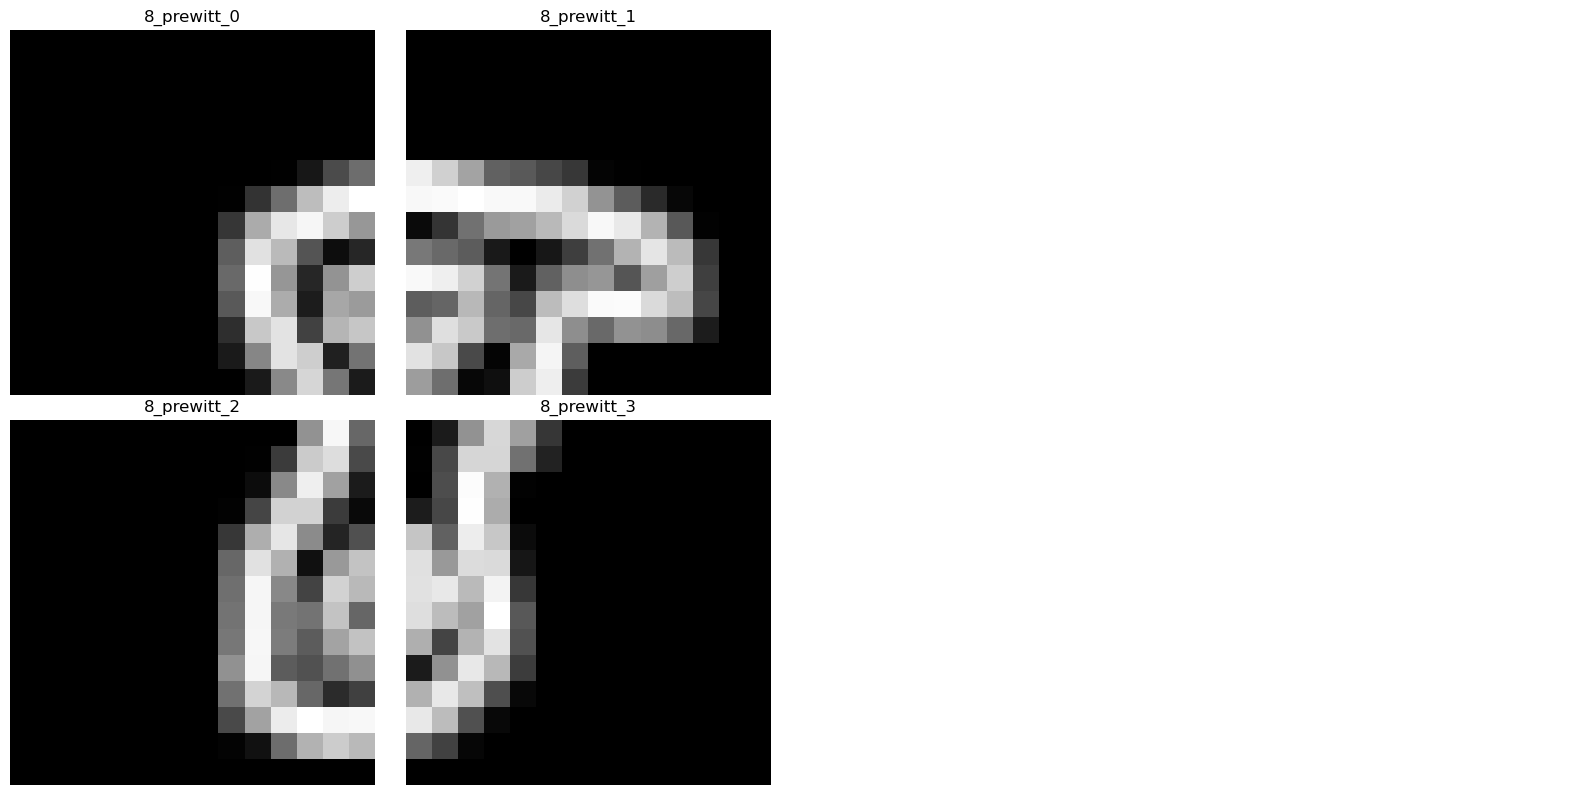

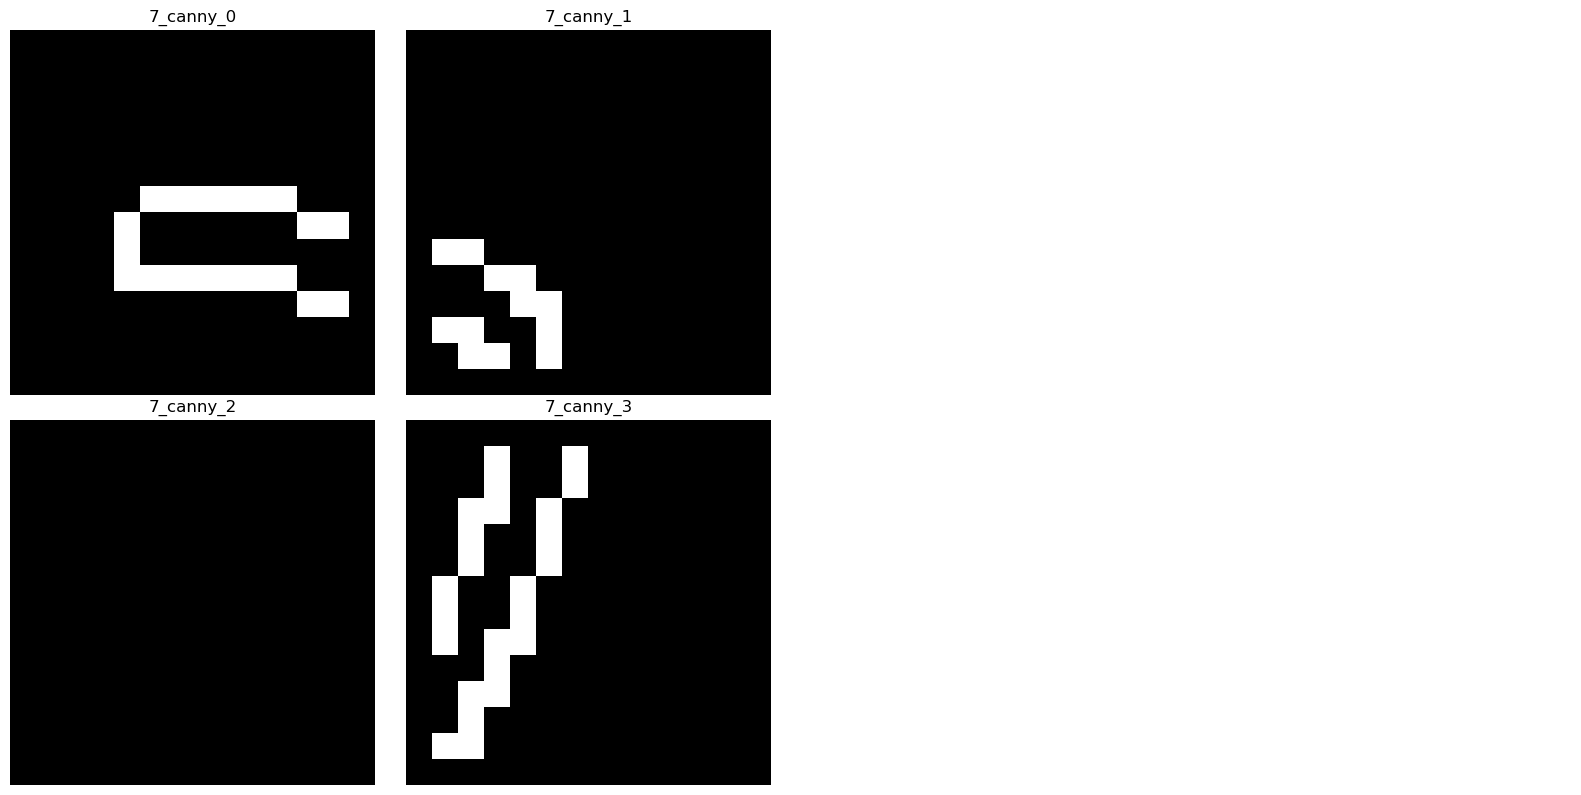

Information of every patch and it's latent variables



[['8_prewitt_0', tensor(51, device='cuda:0')],
 ['8_prewitt_1', tensor(94, device='cuda:0')],
 ['8_prewitt_2', tensor(73, device='cuda:0')],
 ['8_prewitt_3', tensor(63, device='cuda:0')]]

[['7_canny_0', tensor(19, device='cuda:0')],
 ['7_canny_1', tensor(12, device='cuda:0')],
 ['7_canny_2', tensor(0, device='cuda:0')],
 ['7_canny_3', tensor(24, device='cuda:0')]]


Edge list of Graph 1



[('8_prewitt_0', '8_prewitt_1', 51),
 ('8_prewitt_0', '8_prewitt_2', 51),
 ('8_prewitt_0', '8_prewitt_3', 51),
 ('8_prewitt_1', '8_prewitt_0', 94),
 ('8_prewitt_1', '8_prewitt_2', 94),
 ('8_prewitt_1', '8_prewitt_3', 94),
 ('8_prewitt_2', '8_prewitt_0', 73),
 ('8_prewitt_2', '8_prewitt_1', 73),
 ('8_prewitt_2', '8_prewitt_3', 73),
 ('8_prewitt_3', '8_prewitt_0', 63),
 ('8_prewitt_3', '8_prewitt_1', 63),
 ('8_prewitt_3', '8_prewitt_2', 63)]


Edge list of Graph 2



[('7_canny_0', '7_canny_1', 19),
 ('7_canny_0', '7_canny_2', 19),
 ('7_canny_0', '7_canny_3', 19),
 ('7_canny_1', '7_canny_0', 12),
 ('7_canny_1', '7_canny_2', 12),
 ('7_canny_1', '7_canny_3', 12),
 ('7_canny_2', '7_canny_0', 0),
 ('7_canny_2', '7_canny_1', 0),
 ('7_canny_2', '7_canny_3', 0),
 ('7_canny_3', '7_canny_0', 24),
 ('7_canny_3', '7_canny_1', 24),
 ('7_canny_3', '7_canny_2', 24)]


Similarity Score =  209.27016031914346  score closer to 0 means more similar


In [44]:
compute_graph_similarity(5, 'prewitt', 8, 'canny', threshold = 0.95, only_count_edges = True)

# Current Image comparison metrics

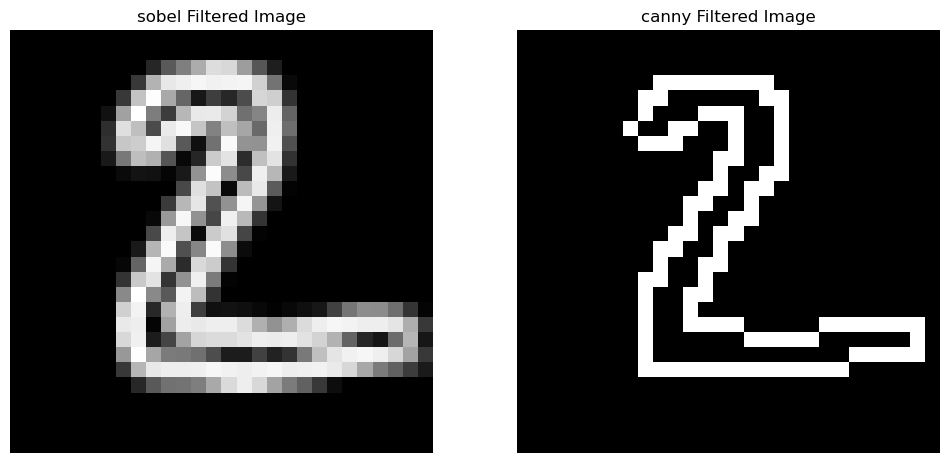

SSIM Score:  0.66 	 Range: -1 to 1 	 Score approaching 1 indicates that the image is similar
RMSE Score:  0.23 	 Range: 0 to inf 	 Score approaching 0 indicates that the image is similar
PSNR Score:  12.93 	 Range: 0 to inf 	 Score approaching inf indicates that the image is similar
IoU  Score:  0.63 	 Range: 0 to 1 		 Score approaching 1 indicates that the image is similar


In [45]:
# Load MNIST dataset using torchvision
mnist_transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Function to apply edge filter using OpenCV
def apply_edge_filter(image, filter_type):
    if filter_type == 'sobel':
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edges = np.sqrt(sobel_x**2 + sobel_y**2).astype(np.float32)
        if (np.max(edges) > 1):
            scale_factor = 1 / np.max(edges)
            edges = (edges * scale_factor).astype(np.float32)
    elif filter_type == 'canny':
        edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200) / 255.0
    elif filter_type == 'prewitt':
        kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        edges_x = cv2.filter2D(image, -1, kernelx)
        edges_y = cv2.filter2D(image, -1, kernely)
        edges = np.sqrt(np.square(edges_x) + np.square(edges_y))
    else:
        raise ValueError("Invalid filter type. Supported types: 'sobel', 'canny', 'prewitt'")
    
    return edges

def compare_images(idx1, edge1, idx2, edge2):
    # Retrieve images from the MNIST dataset
    image1, _ = mnist_dataset[idx1]
    image2, _ = mnist_dataset[idx2]

    # Convert PyTorch tensors to numpy arrays and remove batch dimension
    image1 = image1.squeeze().numpy()
    image2 = image2.squeeze().numpy()

    # Apply specified edge filters to the images
    image1 = apply_edge_filter(image1, edge1)
    image2 = apply_edge_filter(image2, edge2)

    # Display filtered images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(f'{edge1} Filtered Image')
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(f'{edge2} Filtered Image')
    axes[1].axis('off')
    plt.show()

    # Convert images to float32 for SSIM computation
    image1_float = image1.astype(np.float32)
    image2_float = image2.astype(np.float32)

    # Compute SSIM with specified data range [0, 1]
    ssim_score, _ = ssim(image1_float, image2_float, data_range=1.0, full=True)
    
    # Compute RMSE
    rmse_score = np.sqrt(mean_squared_error(image1.ravel(), image2.ravel()))
    
    # Compute PSNR (with safeguard for division by zero)
    if rmse_score > 0:
        psnr_score = psnr(image1_float, image2_float, data_range=1.0)
    else:
        psnr_score = float('inf')  # Set a default value if RMSE is close to zero
    
    # Compute IoU (Jaccard Index)
    threshold = 0.5
    binary_image1 = (image1 > threshold).astype(np.uint8)
    binary_image2 = (image2 > threshold).astype(np.uint8)
    iou_score = jaccard_score(binary_image1.ravel(), binary_image2.ravel())
    
    return ssim_score, rmse_score, psnr_score, iou_score

ssim_score, rmse_score, psnr_score, iou_score = compare_images(1, 'sobel', 1, 'canny')

print(f"SSIM Score: {ssim_score: 0.2f} \t Range: -1 to 1 \t Score approaching 1 indicates that the image is similar")
print(f"RMSE Score: {rmse_score: 0.2f} \t Range: 0 to inf \t Score approaching 0 indicates that the image is similar")
print(f"PSNR Score: {psnr_score: 0.2f} \t Range: 0 to inf \t Score approaching inf indicates that the image is similar")
print(f"IoU  Score: {iou_score: 0.2f} \t Range: 0 to 1 \t\t Score approaching 1 indicates that the image is similar")

# Conclusion

As we can see, our graph-based image structure comparison using latent variables works extremely well compared to just simply counting edges and current similarity metrics